<a href="https://colab.research.google.com/github/alex-smith-uwec/NLP_Spring2025/blob/main/Inauguration_TF_IDF_Scikit_Learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install scikit-learn (not necessary in Colab)

In [3]:
# !pip install sklearn
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.7 MB/s eta 0:00:00


In [6]:

from datasets import load_dataset
# Load the dataset
dataset = load_dataset("jsulz/state-of-the-union-addresses")

# Extract the necessary columns
dates = [item["date"] for item in dataset["train"]]
potus=[item["potus"] for item in dataset["train"]]
texts = [item["speech_html"] for item in dataset["train"]]

# Combine dates, potus texts, then sort by dates
sorted_data = sorted(zip(dates, potus, texts), key=lambda x: x[0])
sorted_dates, sorted_potus,sorted_texts = zip(*sorted_data)

README.md:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

sotu.parquet:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/245 [00:00<?, ? examples/s]

In [9]:
import pandas as pd

# Assuming sorted_dates is a list of strings in 'YYYY-MM-DD' format
# truncated_dates = [date[:4] for date in sorted_dates] # original code causing error
truncated_dates = [str(date)[:4] for date in sorted_dates] # convert Timestamp to string before slicing

#Example to show how to use the truncated dates
#Create a dataframe using the truncated dates
df = pd.DataFrame({'year':truncated_dates, 'potus':sorted_potus})
print(df.head())

   year              potus
0  1790  George Washington
1  1790  George Washington
2  1791  George Washington
3  1792  George Washington
4  1793  George Washington


Import necessary modules and libraries

In [17]:
print(sorted_texts[0][:100])  # Print the first 100 characters of the first element


 I embrace with great satisfaction the opportunity which now presents itself of congratulating you 


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

In [25]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Apply TF-IDF on the plain texts
tfidf_matrix = vectorizer.fit_transform(sorted_texts)

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Add metadata (date and POTUS) to the DataFrame
tfidf_df.insert(0, 'POTUS', sorted_potus)
tfidf_df.insert(0, 'Date', sorted_dates)

# Display the DataFrame
print(tfidf_df.head())


        Date              POTUS       000   01   02   03   04   05   06   07  \
0 1790-01-08  George Washington  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1 1790-12-08  George Washington  0.051271  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2 1791-10-25  George Washington  0.088329  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3 1792-11-06  George Washington  0.037615  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4 1793-12-03  George Washington  0.076314  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   ...  yes  yield  yielded  yielding  york  young  younger  youth      zeal  \
0  ...  0.0    0.0      0.0       0.0   0.0    0.0      0.0    0.0  0.000000   
1  ...  0.0    0.0      0.0       0.0   0.0    0.0      0.0    0.0  0.048639   
2  ...  0.0    0.0      0.0       0.0   0.0    0.0      0.0    0.0  0.000000   
3  ...  0.0    0.0      0.0       0.0   0.0    0.0      0.0    0.0  0.035684   
4  ...  0.0    0.0      0.0       0.0   0.0    0.0      0.0    0.0  0.000000   

   zone  
0   0.0  
1   0.0  
2   0.0 

# **Document similarity**

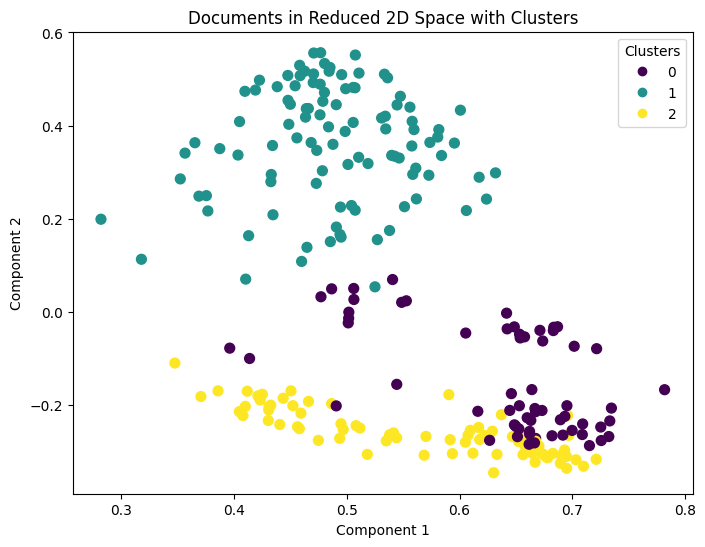

In [44]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=4, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# Apply KMeans Clustering
num_clusters = 3  # Adjust this based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_matrix)

# Plot with cluster coloring
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=clusters, cmap='viridis', s=50)

# Optional: Annotate documents if needed
# for i, doc in enumerate(sorted_texts):
#     plt.annotate(f'Doc {i+1}', (reduced_matrix[i, 0], reduced_matrix[i, 1]))

# Add legend for clusters
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('Documents in Reduced 2D Space with Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
